In [2]:
import os
import pandas as pd
import numpy as np
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
  
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    

def to_sequences(seq_size, df ,data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = df[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        #window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
  
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
 
  # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [59]:
path=os.getcwd() #+ "\Data"
path
files=os.listdir(path)
files

['.ipynb_checkpoints',
 'Emission.ipynb',
 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx',
 'Emission_Cooling_FacilityId.xlsx',
 'Generation_Yearly _For_Emission.xlsx',
 'ghgrp_oris_power_plant_crosswalk_8_5_17+TB+JF.xlsx',
 'pre_processed.xlsx',
 '~$Emission_Cooling_FacilityId.xlsx']

In [5]:
f = 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx'
df_emission = pd.read_excel(f, sheet_name=0, header=5, sort=False, encoding="utf-8")

In [23]:
df_emission

,Facility Id,FRS Id,Facility Name,City,State,Primary NAICS Code,Reporting Year,Industry Type (subparts),Industry Type (sectors),Unit Name,Unit Type,Unit Reporting Method,Unit Maximum Rated Heat Input (mmBTU/hr),Unit CO2 emissions (non-biogenic),Unit Methane (CH4) emissions (mt CO2e),Unit Nitrous Oxide (N2O) emissions (mt CO2e),Unit Biogenic CO2 emissions (metric tons)
0,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130,2017,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.000,9106.1,4.25,5.066,0.0
1,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211112,2016,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.000,9922.2,4.75,5.662,0.0
2,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,2301,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,30433.6,14.00,17.880,0.0
3,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,2302,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,22146.9,10.25,11.920,0.0
4,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,Heatec1,PRH (Process Heater),Tier1/2/3,7.400,32.5,0.00,0.000,0.0
5,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,Heatec2,PRH (Process Heater),Tier1/2/3,7.400,32.5,0.00,0.000,0.0
6,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,2301,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,34949.2,16.25,20.860,0.0
7,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,2302,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,31723.0,14.75,17.880,0.0
8,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,Heatec1,PRH (Process Heater),Tier1/2/3,7.400,32.4,0.00,0.000,0.0
9,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,Heatec2,PRH (Process Heater),Tier1/2/3,7.400,24.8,0.00,0.000,0.0


In [7]:
df_industry_type = pd.read_excel(f, sheet_name=2, header=1, sort=False, encoding="utf-8")

In [8]:
lst = df_industry_type["Subpart Letter"].unique()

In [9]:
df_test = pd.DataFrame(columns=lst)

In [10]:
df_test

,C,D,E,F,G,H,I,K,L,N,...,NN,NN-FRAC,NN-LDC,OO,PP,QQ,RR,SS,TT,UU


In [12]:
df_concatenated = df_emission.append(df_test, sort=False)

In [25]:
#df_concatenated=df_concatenated.drop(df_concatenated[151437:], axis=0)
df_concatenated = df_concatenated.drop(df_concatenated.index[[151437,151491]])

In [26]:
new = df_concatenated["Industry Type (subparts)"].str.split(",", expand = True)
new

,0,1,2,3,4,5
0,C,NN,W,None,None,None
1,C,NN,W,None,None,None
2,C,D,None,None,None,None
3,C,D,None,None,None,None
4,C,D,None,None,None,None
5,C,D,None,None,None,None
6,C,D,None,None,None,None
7,C,D,None,None,None,None
8,C,D,None,None,None,None
9,C,D,None,None,None,None


In [47]:
for idx, row in new.iterrows():
    for x in range(6):
        if new.loc[idx, x] != None:
            s=new.loc[idx, x]
            df_concatenated.loc[idx, s] = 1

In [54]:
FT = df_industry_type["Facility Type"].unique()

In [55]:
df_temp = pd.DataFrame(columns=FT)

In [56]:
df_temp

,Direct Emitter,Onshore Oil & Gas Production,Gathering & Boosting,Transmission Pipelines,LDC - Direct Emissions,SF6 from Elec. Equip.,Supplier,CO2 Injection


In [78]:
df_concatenated.dtypes

Facility Id                                     float64
FRS Id                                          float64
Facility Name                                    object
City                                             object
State                                            object
Primary NAICS Code                              float64
Reporting Year                                  float64
Industry Type (subparts)                         object
Industry Type (sectors)                          object
Unit Name                                        object
Unit Type                                        object
Unit Reporting Method                            object
Unit Maximum Rated Heat Input (mmBTU/hr)        float64
Unit CO2 emissions (non-biogenic)               float64
Unit Methane (CH4) emissions (mt CO2e)          float64
Unit Nitrous Oxide (N2O) emissions (mt CO2e)    float64
Unit Biogenic CO2 emissions (metric tons)       float64
AA                                              

In [65]:
df_concatenated = df_concatenated.drop('Facility Type', axis=1)
df_concatenated = df_concatenated.drop('Name of industry', axis=1)
df_concatenated = df_concatenated.drop('Subpart Letter', axis=1)

In [67]:
df_concatenated = df_concatenated.append(df_temp, sort=False)

In [80]:
df_concatenated['C'] = pd.to_numeric(df_concatenated['C'], errors='coerce')
df_concatenated['D'] = pd.to_numeric(df_concatenated['D'], errors='coerce')
df_concatenated['E'] = pd.to_numeric(df_concatenated['E'], errors='coerce')
df_concatenated['F'] = pd.to_numeric(df_concatenated['F'], errors='coerce')
df_concatenated['G'] = pd.to_numeric(df_concatenated['G'], errors='coerce')
df_concatenated['H'] = pd.to_numeric(df_concatenated['H'], errors='coerce')
df_concatenated['I'] = pd.to_numeric(df_concatenated['I'], errors='coerce')
df_concatenated['K'] = pd.to_numeric(df_concatenated['K'], errors='coerce')
df_concatenated['L'] = pd.to_numeric(df_concatenated['L'], errors='coerce')
df_concatenated['N'] = pd.to_numeric(df_concatenated['N'], errors='coerce')
df_concatenated['O'] = pd.to_numeric(df_concatenated['O'], errors='coerce')
df_concatenated['P'] = pd.to_numeric(df_concatenated['P'], errors='coerce')
df_concatenated['Q'] = pd.to_numeric(df_concatenated['Q'], errors='coerce')
df_concatenated['R'] = pd.to_numeric(df_concatenated['R'], errors='coerce')
df_concatenated['S'] = pd.to_numeric(df_concatenated['S'], errors='coerce')
df_concatenated['T'] = pd.to_numeric(df_concatenated['T'], errors='coerce')
df_concatenated['U'] = pd.to_numeric(df_concatenated['U'], errors='coerce')
df_concatenated['V'] = pd.to_numeric(df_concatenated['V'], errors='coerce')
df_concatenated['W'] = pd.to_numeric(df_concatenated['W'], errors='coerce')
df_concatenated['W-ONSH'] = pd.to_numeric(df_concatenated['W-ONSH'], errors='coerce')
df_concatenated['W-GB'] = pd.to_numeric(df_concatenated['W-GB'], errors='coerce')
df_concatenated['W-PROC'] = pd.to_numeric(df_concatenated['W-PROC'], errors='coerce')
df_concatenated['W-NGTC'] = pd.to_numeric(df_concatenated['W-NGTC'], errors='coerce')
df_concatenated['W-TRANS'] = pd.to_numeric(df_concatenated['W-TRANS'], errors='coerce')
df_concatenated['W-UNSTG'] = pd.to_numeric(df_concatenated['W-UNSTG'], errors='coerce')
df_concatenated['W-LNGSTG'] = pd.to_numeric(df_concatenated['W-LNGSTG'], errors='coerce')
df_concatenated['W-LNGIE'] = pd.to_numeric(df_concatenated['W-LNGIE'], errors='coerce')
df_concatenated['W-LDC'] = pd.to_numeric(df_concatenated['W-LDC'], errors='coerce')
df_concatenated['X'] = pd.to_numeric(df_concatenated['X'], errors='coerce')
df_concatenated['Y'] = pd.to_numeric(df_concatenated['Y'], errors='coerce')
df_concatenated['Z'] = pd.to_numeric(df_concatenated['Z'], errors='coerce')
df_concatenated['AA'] = pd.to_numeric(df_concatenated['AA'], errors='coerce')
df_concatenated['BB'] = pd.to_numeric(df_concatenated['BB'], errors='coerce')
df_concatenated['CC'] = pd.to_numeric(df_concatenated['CC'], errors='coerce')
df_concatenated['DD'] = pd.to_numeric(df_concatenated['DD'], errors='coerce')
df_concatenated['EE'] = pd.to_numeric(df_concatenated['EE'], errors='coerce')
df_concatenated['FF'] = pd.to_numeric(df_concatenated['FF'], errors='coerce')
df_concatenated['GG'] = pd.to_numeric(df_concatenated['GG'], errors='coerce')
df_concatenated['HH'] = pd.to_numeric(df_concatenated['HH'], errors='coerce')
df_concatenated['II'] = pd.to_numeric(df_concatenated['II'], errors='coerce')
df_concatenated['LL'] = pd.to_numeric(df_concatenated['LL'], errors='coerce')
df_concatenated['MM'] = pd.to_numeric(df_concatenated['MM'], errors='coerce')
df_concatenated['MM – REF'] = pd.to_numeric(df_concatenated['MM – REF'], errors='coerce')
df_concatenated['MM – IMP'] = pd.to_numeric(df_concatenated['MM – IMP'], errors='coerce')
df_concatenated['MM – EXP'] = pd.to_numeric(df_concatenated['MM – EXP'], errors='coerce')
df_concatenated['NN'] = pd.to_numeric(df_concatenated['NN'], errors='coerce')
df_concatenated['NN-FRAC'] = pd.to_numeric(df_concatenated['NN-FRAC'], errors='coerce')
df_concatenated['NN-LDC'] = pd.to_numeric(df_concatenated['NN-LDC'], errors='coerce')
df_concatenated['OO'] = pd.to_numeric(df_concatenated['OO'], errors='coerce')
df_concatenated['PP'] = pd.to_numeric(df_concatenated['PP'], errors='coerce')
df_concatenated['QQ'] = pd.to_numeric(df_concatenated['QQ'], errors='coerce')
df_concatenated['RR'] = pd.to_numeric(df_concatenated['RR'], errors='coerce')
df_concatenated['SS'] = pd.to_numeric(df_concatenated['SS'], errors='coerce')
df_concatenated['TT'] = pd.to_numeric(df_concatenated['TT'], errors='coerce')
df_concatenated['UU'] = pd.to_numeric(df_concatenated['UU'], errors='coerce')
df_concatenated['Direct Emitter'] = pd.to_numeric(df_concatenated['Direct Emitter'], errors='coerce')
df_concatenated['Onshore Oil & Gas Production'] = pd.to_numeric(df_concatenated['Onshore Oil & Gas Production'], errors='coerce')
df_concatenated['Gathering & Boosting'] = pd.to_numeric(df_concatenated['Gathering & Boosting'], errors='coerce')
df_concatenated['Transmission Pipelines'] = pd.to_numeric(df_concatenated['Transmission Pipelines'], errors='coerce')
df_concatenated['LDC - Direct Emissions'] = pd.to_numeric(df_concatenated['LDC - Direct Emissions'], errors='coerce')
df_concatenated['SF6 from Elec. Equip.'] = pd.to_numeric(df_concatenated['SF6 from Elec. Equip.'], errors='coerce')
df_concatenated['Supplier'] = pd.to_numeric(df_concatenated['Supplier'], errors='coerce')
df_concatenated['CO2 Injection'] = pd.to_numeric(df_concatenated['CO2 Injection'], errors='coerce')           

In [82]:
for idx, row in df_concatenated.iterrows():
    if(df_concatenated.loc[idx,'C']==1 | df_concatenated.loc[idx,'D']==1 | df_concatenated.loc[idx,'E']==1 | df_concatenated.loc[idx,'F']==1 | df_concatenated.loc[idx,'G']==1 | df_concatenated.loc[idx,'H']==1 | df_concatenated.loc[idx,'I']==1 | df_concatenated.loc[idx,'K']==1 | df_concatenated.loc[idx,'L']==1 | df_concatenated.loc[idx,'N']==1 | df_concatenated.loc[idx,'O']==1 | df_concatenated.loc[idx,'P']==1 | df_concatenated.loc[idx,'Q']==1 | df_concatenated.loc[idx,'R']==1 | df_concatenated.loc[idx,'S']==1 | df_concatenated.loc[idx,'T']==1 | df_concatenated.loc[idx,'U']==1 | df_concatenated.loc[idx,'V']==1 | df_concatenated.loc[idx,'W']==1 | df_concatenated.loc[idx,'W-OFFSH']==1 | df_concatenated.loc[idx,'W-PROC']==1 | df_concatenated.loc[idx,'W-NGTC']==1 | df_concatenated.loc[idx,'W-UNSTG']==1 | df_concatenated.loc[idx,'W-LNGSTG']==1 | df_concatenated.loc[idx,'W-LNGIE']==1 | df_concatenated.loc[idx,'X']==1 | df_concatenated.loc[idx,'Y']==1 | df_concatenated.loc[idx,'Z']==1 | df_concatenated.loc[idx,'AA']==1 | df_concatenated.loc[idx,'BB']==1 | df_concatenated.loc[idx,'CC']==1 | df_concatenated.loc[idx,'EE']==1 | df_concatenated.loc[idx,'FF']==1 | df_concatenated.loc[idx,'GG']==1 | df_concatenated.loc[idx,'HH']==1 | df_concatenated.loc[idx,'II']==1 | df_concatenated.loc[idx,'SS']==1 | df_concatenated.loc[idx,'TT']==1):
        df_concatenated.loc[idx,'Direct Emitter'] = 1
    if(df_concatenated.loc[idx,'RR']==1 | df_concatenated.loc[idx,'UU'] ==1):
        df_concatenated.loc[idx,'CO2 Injection'] = 1
    if(df_concatenated.loc[idx,'W-GB']==1):
        df_concatenated.loc[idx,'Gathering & Boosting'] = 1
    if(df_concatenated.loc[idx,'W-LDC']==1):
        df_concatenated.loc[idx,'LDC - Direct Emissions'] = 1
    if(df_concatenated.loc[idx,'W-ONSH']==1):
        df_concatenated.loc[idx,'Onshore Oil & Gas Production'] = 1
    if(df_concatenated.loc[idx,'DD']==1):
        df_concatenated.loc[idx,'SF6 from Elec. Equip.'] = 1
    if(df_concatenated.loc[idx,'DD']==1):
        df_concatenated.loc[idx,'SF6 from Elec. Equip.'] = 1
    if(df_concatenated.loc[idx,'LL']==1 | df_concatenated.loc[idx,'MM']==1 | df_concatenated.loc[idx,'MM – REF']==1 | df_concatenated.loc[idx,'MM – IMP']==1 | df_concatenated.loc[idx,'MM – EXP']==1 | df_concatenated.loc[idx,'NN']==1 | df_concatenated.loc[idx,'NN-FRAC']==1 | df_concatenated.loc[idx,'NN-LDC']==1 | df_concatenated.loc[idx,'OO']==1 | df_concatenated.loc[idx,'PP']==1 | df_concatenated.loc[idx,'QQ']==1):
        df_concatenated.loc[idx,'Supplier']=1
    if(df_concatenated.loc[idx,'W-TRANS']==1):
        df_concatenated.loc[idx,'Transmission Pipelines'] = 1

TypeError: unsupported operand type(s) for |: 'int' and 'numpy.float64'

# Fuel-Data and Generation

In [3]:
path=os.getcwd() #+ "\Data"
path
files=os.listdir(path)
files

['.ipynb_checkpoints',
 '2B4CDB60',
 'Emission.ipynb',
 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx',
 'Emission_Cooling_FacilityId.xlsx',
 'Generation_Yearly _For_Emission.xlsx',
 'ghgrp_oris_power_plant_crosswalk_8_5_17+TB+JF.xlsx',
 'pre_processed.xlsx',
 'pre_processed1.xlsx',
 '~$emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx',
 '~$Emission_Cooling_FacilityId.xlsx']

In [5]:
# Gets the excel file into dataframe 
f = 'Emission_Cooling_FacilityId.xlsx'
df_emi_cool = pd.read_excel(f, sheet_name=3, usecols="A,B,D,F,H,I,J,L,M,P,Q,R", header=0, sort=False, encoding="utf-8")

In [6]:
df_emi_cool.dtypes

Facility Id                                           int64
Plant Code                                           object
Facility Name                                        object
State                                                object
Reporting Year                                        int64
Industry Type (subparts)                             object
Industry Type (sectors)                              object
General Fuel Type                                    object
Specific Fuel Type                                   object
Fuel CO2 emissions (non-biogenic)  (metric tons)    float64
Fuel Methane (CH4) emissions (mt CO2e)              float64
Fuel Nitrous Oxide (N2O) emissions (mt CO2e)        float64
dtype: object

#### Selects rows with Industry Type = Power Plants

In [8]:
df_emi_cool.loc[(df_emi_cool['Industry Type (sectors)'] != 'Power Plants')]

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Specific Fuel Type,Fuel CO2 emissions (non-biogenic) (metric tons),Fuel Methane (CH4) emissions (mt CO2e),Fuel Nitrous Oxide (N2O) emissions (mt CO2e)
0,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,CA,2017,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",Natural Gas,Natural Gas (Weighted U.S. Average),9106.100,4.25,5.066
1,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,CA,2016,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",Natural Gas,Natural Gas (Weighted U.S. Average),9922.200,4.75,5.662
30,1006394,NaN,29-6 #2 Central Delivery Point,NM,2015,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),15375.700,7.25,8.642
31,1006394,NaN,29-6 #2 Central Delivery Point,NM,2014,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),15337.300,7.25,8.642
32,1006394,NaN,29-6 #2 Central Delivery Point,NM,2013,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),14561.100,6.75,8.940
33,1006394,NaN,29-6 #2 Central Delivery Point,NM,2012,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),10861.600,5.00,5.960
34,1006394,NaN,29-6 #2 Central Delivery Point,NM,2011,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),19368.400,9.25,11.920
35,1002885,NaN,30-5 Central Delivery Point Compressor Station,NM,2015,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),22483.500,10.50,12.516
36,1002885,NaN,30-5 Central Delivery Point Compressor Station,NM,2014,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),21861.100,10.25,12.218
37,1002885,NaN,30-5 Central Delivery Point Compressor Station,NM,2013,C,Petroleum and Natural Gas Systems,Natural Gas,Natural Gas (Weighted U.S. Average),22307.300,10.50,11.920


In [9]:
df_emi_cool=df_emi_cool[~(df_emi_cool['Industry Type (sectors)'] != 'Power Plants')]

In [10]:
# Renaming attributes
df_emi_cool.rename(columns={'Fuel CO2 emissions (non-biogenic)  (metric tons)': 'Fuel_CO2_Emissions', 
                            'Fuel Methane (CH4) emissions (mt CO2e)': 'Fuel_Methan_CH4_Emissions',
                            'Fuel Nitrous Oxide (N2O) emissions (mt CO2e)':'Fuel_Nitrous_Oxide_N2O_Emissions'}, inplace=True);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
# Saving dataframe
df_Emission_Gen = df_emi_cool

#### Aggregating all emissions

In [12]:
df_Emission_Gen['Total_Emission']=df_Emission_Gen['Fuel_CO2_Emissions']+df_Emission_Gen['Fuel_Methan_CH4_Emissions']+df_Emission_Gen['Fuel_Nitrous_Oxide_N2O_Emissions']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
df_Emission_Gen

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Specific Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission
2,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),30433.60,14.00,17.88,30465.48
3,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),22146.90,10.25,11.92,22169.07
4,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.50,0.00,0.00,32.50
5,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.50,0.00,0.00,32.50
6,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),34949.20,16.25,20.86,34986.31
7,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),31723.00,14.75,17.88,31755.63
8,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.40,0.00,0.00,32.40
9,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),24.80,0.00,0.00,24.80
10,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),35203.30,16.25,20.86,35240.41
11,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),31996.00,14.75,17.88,32028.63


#### Drops null and 'No Match' Plant Codes 

In [14]:
d=df_Emission_Gen.dropna(subset=['Plant Code'])

In [15]:
d.loc[(d['Plant Code'] == 'No Match')]

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Specific Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission
1376,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2017,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),138488.9,65.25,77.778,138631.928
1377,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2016,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),108561.3,51.25,61.090,108673.640
1378,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2015,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),110923.9,52.25,62.282,111038.432
1379,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2014,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),118072.2,55.75,66.454,118194.404
1380,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2013,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),137647.7,64.75,77.182,137789.632
1381,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2012,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),117865.9,55.50,66.156,117987.556
1382,1006553,No Match,"Advanced Tri-Gen Power Systems, LLC",IL,2011,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),130547.1,61.50,73.308,130681.908
15629,1005525,No Match,BELLEFIELD BOILER PLANT,PA,2017,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),57013.3,26.75,31.886,57071.936
15630,1005525,No Match,BELLEFIELD BOILER PLANT,PA,2016,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),56425.0,26.50,31.588,56483.088
15631,1005525,No Match,BELLEFIELD BOILER PLANT,PA,2015,C,Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),45320.1,21.25,25.330,45366.680


In [16]:
d=d[~(d['Plant Code'] == 'No Match')]

In [17]:
d.loc[(d['Plant Code'] == 'No Match')]

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Specific Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission
2,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),30433.60,14.00,17.88,30465.48
3,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),22146.90,10.25,11.92,22169.07
4,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.50,0.00,0.00,32.50
5,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.50,0.00,0.00,32.50
6,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),34949.20,16.25,20.86,34986.31
7,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),31723.00,14.75,17.88,31755.63
8,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),32.40,0.00,0.00,32.40
9,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),24.80,0.00,0.00,24.80
10,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),35203.30,16.25,20.86,35240.41
11,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,Natural Gas (Weighted U.S. Average),31996.00,14.75,17.88,32028.63


In [18]:
# Drops Emission columns as we will use Total Emission column
d=d.drop(['Fuel_CO2_Emissions', 'Fuel_Methan_CH4_Emissions', 'Fuel_Nitrous_Oxide_N2O_Emissions'], axis=1)

In [30]:
d['General Fuel Type'].unique()

array(['Natural Gas', 'Petroleum Products', 'Coal', 'Other'], dtype=object)

In [29]:
d=df_Emission_Gen.dropna(subset=['General Fuel Type'])

In [20]:
d['Specific Fuel Type'].unique()

array(['Natural Gas (Weighted U.S. Average)', 'Distillate Fuel Oil No. 2',
       'Residual Fuel Oil No. 6', 'Kerosene', 'Bituminous',
       'Subbituminous', 'Distillate Fuel Oil No. 4', 'Propane',
       'Liquefied petroleum gases (LPG)', 'Petroleum Coke', 'Coke',
       'Mixed (Industrial sector)', 'Tires', 'Used Oil', 'Fuel Gas',
       'Agricultural Byproducts', 'Distillate Fuel Oil No. 1',
       'Mixed (Electric Power sector)',
       'Wood and Wood Residuals (dry basis)', 'Municipal Solid Waste',
       'Lignite', 'Wood and Wood Residuals', 'Other Oil (>401 deg F)',
       'Solid Byproducts', 'Propane Gas', 'Landfill Gas', 'Lubricants',
       'Kerosene-Type Jet Fuel', 'Biogas (Captured methane)', nan,
       'Biodiesel', 'Other Biomass Gases', 'Biodiesel (100%)',
       'Naphtha (<401 deg F)', 'Blast Furnace Gas',
       'Residual Fuel Oil No. 5', 'Natural Gasoline', 'Vegetable Oil',
       'Anthracite', 'Motor Gasoline', 'Butane', 'Coke Oven Gas',
       'Coal Coke'], dtype=o

#### Group by Year Reporting Year and plant Code

In [49]:
# Not using General Fuel Type because it has different fuel type for same year and same plant code  
d_new = d.groupby(['Facility Id', 'Reporting Year','Plant Code', 'State'], as_index=False).agg({'Total_Emission': 'sum'})

In [50]:
d_new

,Facility Id,Reporting Year,Plant Code,State,Total_Emission
0,1000001,2011,54537,WA,35878.164
1,1000001,2012,54537,WA,14716.820
2,1000001,2013,54537,WA,395316.620
3,1000001,2014,54537,WA,333194.160
4,1000001,2015,54537,WA,405726.250
5,1000001,2016,54537,WA,354146.680
6,1000001,2017,54537,WA,350893.080
7,1000033,2011,50300,CA,62422.564
8,1000033,2012,50300,CA,65686.252
9,1000033,2013,50300,CA,56025.440


In [51]:
f1 = 'Generation_Yearly _For_Emission.xlsx'
df_generation = pd.read_excel(f1, sheet_name=0, header=0, sort=False)

In [52]:
df_generation.dtypes

Plant Code          int64
Reporting Year      int64
Generation        float64
dtype: object

In [53]:
d_new.dtypes

Facility Id         int64
Reporting Year      int64
Plant Code         object
State              object
Total_Emission    float64
dtype: object

In [54]:
d_new['Plant Code'] = pd.to_numeric(d_new['Plant Code'], errors='coerce')

In [93]:
df_result = d_new.merge(df_generation, on=['Plant Code','Reporting Year'])

In [94]:
df_result

,Facility Id,Reporting Year,Plant Code,State,Total_Emission,Generation
0,1000001,2011,54537.0,WA,35878.164,1.029530e+05
1,1000001,2012,54537.0,WA,14716.820,4.331100e+04
2,1000001,2013,54537.0,WA,395316.620,8.693880e+05
3,1000001,2014,54537.0,WA,333194.160,7.230520e+05
4,1000001,2015,54537.0,WA,405726.250,8.688480e+05
5,1000001,2016,54537.0,WA,354146.680,7.423470e+05
6,1000001,2017,54537.0,WA,350893.080,7.413570e+05
7,1000033,2011,50300.0,CA,62422.564,1.204010e+05
8,1000033,2012,50300.0,CA,65686.252,1.272330e+05
9,1000033,2013,50300.0,CA,56025.440,1.065320e+05


In [95]:
# One-Hot Encoding
#encode_text_dummy(df_result, 'General Fuel Type')
encode_text_dummy(df_result, 'Reporting Year')
encode_text_dummy(df_result, 'State')

In [96]:
df_result['Generation'].isna().unique()

array([False])

In [97]:
df_result['Total_Emission'].isna().unique()

array([False])

In [98]:
df_result.to_csv('pre_processed1.csv', encoding='utf-8', index=False)

In [99]:
df_result.dtypes

Facility Id              int64
Plant Code             float64
Total_Emission         float64
Generation             float64
Reporting Year-2011      uint8
Reporting Year-2012      uint8
Reporting Year-2013      uint8
Reporting Year-2014      uint8
Reporting Year-2015      uint8
Reporting Year-2016      uint8
Reporting Year-2017      uint8
State-AK                 uint8
State-AL                 uint8
State-AR                 uint8
State-AZ                 uint8
State-CA                 uint8
State-CO                 uint8
State-CT                 uint8
State-DC                 uint8
State-DE                 uint8
State-FL                 uint8
State-GA                 uint8
State-HI                 uint8
State-IA                 uint8
State-ID                 uint8
State-IL                 uint8
State-IN                 uint8
State-KS                 uint8
State-KY                 uint8
State-LA                 uint8
                        ...   
State-ME                 uint8
State-MI

In [100]:
# Feature normalization
encode_numeric_range(df_result, 'Generation')

In [102]:
#df_final=df_result.drop(['Reporting Year','Plant Code','Facility Id','State'],axis=1)
#df_final=df_result.drop(['Plant Code','Facility Id','State'],axis=1)
df_final=df_result.drop(['Plant Code','Facility Id'],axis=1)

In [103]:
df_final

,Total_Emission,Generation,Reporting Year-2011,Reporting Year-2012,Reporting Year-2013,Reporting Year-2014,Reporting Year-2015,Reporting Year-2016,Reporting Year-2017,State-AK,...,State-SD,State-TN,State-TX,State-UT,State-VA,State-VT,State-WA,State-WI,State-WV,State-WY
0,35878.164,0.006940,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,14716.820,0.004498,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,395316.620,0.038322,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,333194.160,0.032331,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,405726.250,0.038300,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,354146.680,0.033121,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,350893.080,0.033080,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
7,62422.564,0.007655,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,65686.252,0.007934,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,56025.440,0.007087,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Linear Regression Model

In [104]:
x,y = to_xy(df_final,"Total_Emission")

Coefficients: 
 [ 1.9855176e+07 -3.6010426e+08 -3.6024666e+08 -3.6021421e+08
 -3.6018979e+08 -3.6025402e+08 -3.6031456e+08 -3.6034938e+08
 -2.9977070e+09 -2.9980301e+09 -2.9976376e+09 -2.9977541e+09
 -2.9980132e+09 -2.9976589e+09 -2.9981540e+09 -2.9977142e+09
 -2.9979602e+09 -2.9986939e+09 -2.9979512e+09 -2.9977039e+09
 -2.9974781e+09 -2.9978696e+09 -2.9974743e+09 -2.9974676e+09
 -2.9974236e+09 -2.9972073e+09 -2.9980854e+09 -2.9980774e+09
 -2.9976315e+09 -2.9980393e+09 -2.9975153e+09 -2.9976218e+09
 -2.9974950e+09 -2.9982922e+09 -2.9971438e+09 -2.9979046e+09
 -2.9968886e+09 -2.9974764e+09 -2.9981885e+09 -2.9983032e+09
 -2.9975690e+09 -2.9982420e+09 -2.9979387e+09 -2.9976428e+09
 -2.9979302e+09 -2.9981338e+09 -2.9979133e+09 -2.9981553e+09
 -2.9977933e+09 -2.9976627e+09 -2.9972375e+09 -2.9978916e+09
 -2.9974303e+09 -2.9979041e+09 -2.9978660e+09 -2.9979702e+09
 -2.9976320e+09 -2.9971699e+09 -2.9968983e+09]
Final score (RMSE): 941162.0
Variance score: 0.86


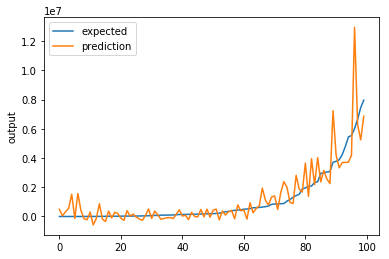

In [105]:
#Linear Regression
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
#XTrain, XTest, YTrain, YTest = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
liReg_pred = regr.predict(x_test)

print('Coefficients: \n', regr.coef_)
score = np.sqrt(metrics.mean_squared_error(liReg_pred,y_test))
print("Final score (RMSE): {}".format(score))
print('Variance score: %.2f' % r2_score(y_test, liReg_pred))
# Plot the chart
chart_regression(liReg_pred.flatten()[0:100],y_test[0:100])

## Tensorflow Regression Model

In [106]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath=os.getcwd()+"\weights\best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()

    model.add(Dense(400, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=10)

print('Training finished...Loading the best model')  
print()
model.load_weights(os.getcwd()+"\weights\best_weights.hdf5") # load weights from best model


0
Train on 6828 samples, validate on 2277 samples
Epoch 1/10
 - 2s - loss: 9143544552325.0254 - val_loss: 5906927068096.5898
Epoch 2/10
 - 1s - loss: 6587229107987.6455 - val_loss: 5044113014251.5381
Epoch 3/10
 - 1s - loss: 5302353101011.1592 - val_loss: 3726697880668.1914
Epoch 4/10
 - 1s - loss: 3158335013737.4292 - val_loss: 1740441858798.1238
Epoch 5/10
 - 1s - loss: 1280301717301.2395 - val_loss: 824043552185.1699
Epoch 6/10
 - 1s - loss: 879123884724.2648 - val_loss: 710276573614.8265
Epoch 7/10
 - 1s - loss: 815001540357.2490 - val_loss: 676743332365.2666
Epoch 8/10
 - 1s - loss: 776585232028.8693 - val_loss: 648940727918.8546
Epoch 9/10
 - 1s - loss: 741871460539.1635 - val_loss: 624135232107.7067
Epoch 10/10
 - 1s - loss: 712838815288.0890 - val_loss: 611335081715.9701
1
Train on 6828 samples, validate on 2277 samples
Epoch 1/10
 - 2s - loss: 9321546127589.1562 - val_loss: 6088037390660.6943
Epoch 2/10
 - 1s - loss: 6707348572914.6523 - val_loss: 5155960912538.4766
Epoch 3/10

OSError: Unable to open file (unable to open file: name = 'C:\Users\preey\Downloads\Master's Project\Emission\weightsest_weights.hdf5', errno = 22, error message = 'Invalid argument', flags = 0, o_flags = 0)

Shape: (2277, 1)
Final score (RMSE): 786393.6875
R2 score: 0.902491


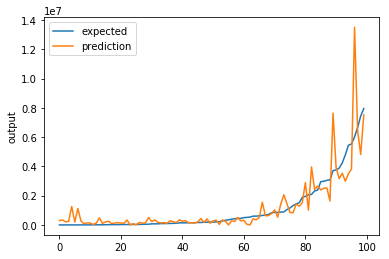

In [107]:
from sklearn.metrics import r2_score
pred = model.predict(x_test)
print("Shape: {}".format(pred.shape))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
print('R2 score: %2f' % r2_score(y_test,pred))
# Plot the chart
chart_regression(pred.flatten()[0:100],y_test[0:100])